**Issue#3 - Traversal of the space of train/test splits.**

Fix for #3: https://github.com/mozilla/PRESC/issues/3

In this notebook, we will do train-test splits experiment and see how the accuracy of the model varies. we will use SVM classifier along with MinMax data Transformation and Hyperparameter tuning as per my notebook for issue #2. I chose that settings because using transformation and hyperparameter tuning improved my results in my previous experiments for issue #2

In this notebook, I have removed outliers.

***Steps***
1. Data Exploration and Outlier Fixing
    - Removing Outliers 
2. Data Transformation(MinmaxScaler)
3. Hyperparameter Tuning(GridCV)
       - I am using GridSearchCV function to find the optimal parameters i.e parameter tuning. I will be using rbf(Radial basis kernel). The optimal params value for c and gamma was based on this kaggle kernel (https://www.kaggle.com/rajansharma780/vehicle/kernels).
4. Training using multiple split ratios
5. Display result in tabular format

**References:**
1. https://scikit-learn.org
2. https://www.kaggle.com/rajansharma780/vehicle/kernels

In [1]:
# Ignore all the future warning and deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
pd.set_option("display.precision", 2) 
    
from sklearn.model_selection import GridSearchCV
from issue3_helper import test_train_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [2]:
# Read the data
df = pd.read_csv("../../datasets/vehicles.csv")

In [3]:
# Set Feature and Label Column
feature_cols = ['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO',
       'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO',
       'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY',
       'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR',
       'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR']
label_col = ['Class']

In [4]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
COMPACTNESS,846.0,93.68,8.23,73.0,87.00,93.0,100.0,119.0
CIRCULARITY,846.0,44.86,6.17,33.0,40.00,44.0,49.0,59.0
DISTANCE_CIRCULARITY,846.0,82.09,15.77,40.0,70.00,80.0,98.0,112.0
RADIUS_RATIO,846.0,168.94,33.47,104.0,141.00,167.0,195.0,333.0
PR.AXIS_ASPECT_RATIO,846.0,61.69,7.89,47.0,57.00,61.0,65.0,138.0
MAX.LENGTH_ASPECT_RATIO,846.0,8.57,4.60,2.0,7.00,8.0,10.0,55.0
SCATTER_RATIO,846.0,168.84,33.24,112.0,146.25,157.0,198.0,265.0
ELONGATEDNESS,846.0,40.93,7.81,26.0,33.00,43.0,46.0,61.0
PR.AXIS_RECTANGULARITY,846.0,20.58,2.59,17.0,19.00,20.0,23.0,29.0
MAX.LENGTH_RECTANGULARITY,846.0,148.00,14.52,118.0,137.00,146.0,159.0,188.0


***Data Insight***

The data looks clean as there are no null values out of total 846 entries. All of the fields are of integer types. The last column is the target value which will be used as label. There are four vehicle categories: 'van', 'saab', 'bus', 'opel'. This is multi-class classifcation problem.

From above statistics, Standard deviation(scatteredness) seems high for SCALED_VARIANCE_MINOR field. For other mean and standard deviation looks fine. And the distribution for each feature has many variations : unimodal, bimodal and multimodal.

There are few outliers in some features such as : MAX.LENGTH_ASPECT_RATIO, SKEWNESS_ABOUT_MAJOR.

Since we have outliers in our data, lets create boxplot graph to identify min, max values and outliers.

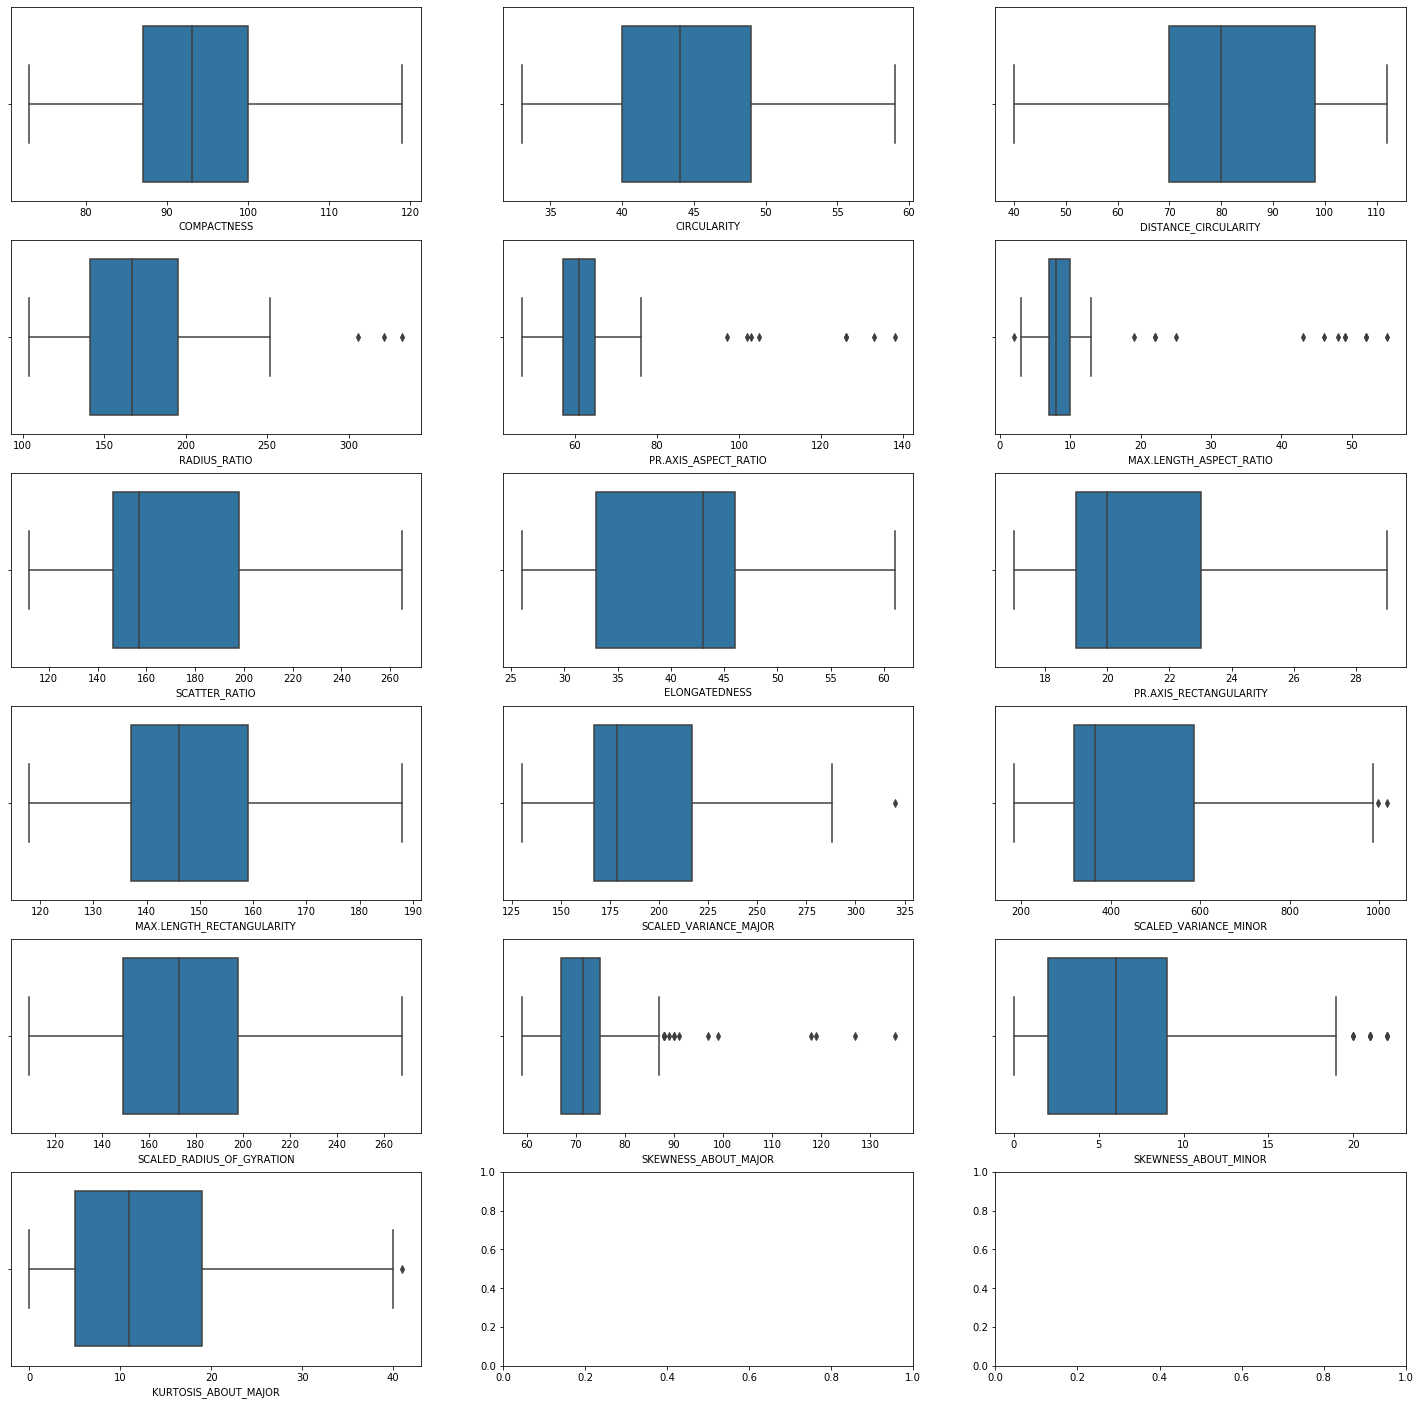

In [5]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.boxplot(df[column],ax=axes[i//3,i%3], dodge=False, whis=1.5)

**Fixing Outliers**

Based on the above graph, these are the features/columns that have outliers:
1. RADIUS_RATIO                                                                               
2. PR.AXIS_ASPECT_RATIO                                                                            
3. MAX.LENGTH_ASPECT_RATIO
4. SCALED_VARIANCE_MAJOR
5. SCALED_VARIANCE_MINOR 
6. SKEWNESS_ABOUT_MAJOR 
7. SKEWNESS_ABOUT_MINOR
8. KURTOSIS_ABOUT_MAJOR

We will fix all the rows that have outliers by removing those data rows because outliers in data can result in inaccurate models.

There are 31 rows with outliers out of 846 rows.

In [6]:
# Max value based on boxplot to filter outliers
df_columns_with_outliers = pd.DataFrame([[255, 77, 13, 288, 980, 88, 19, 40]], columns=['RADIUS_RATIO', 
                                                                                'PR.AXIS_ASPECT_RATIO', 
                                                                                'MAX.LENGTH_ASPECT_RATIO', 
                                                                                'SCALED_VARIANCE_MAJOR', 
                                                                                'SCALED_VARIANCE_MINOR', 
                                                                                'SKEWNESS_ABOUT_MAJOR', 
                                                                                'SKEWNESS_ABOUT_MINOR', 
                                                                                'KURTOSIS_ABOUT_MAJOR'])

# Outliers fixing by removing them
df_new = df.copy()

# Remove outliers based on max value identified earlier from boxplot
for i, column in enumerate(df_columns_with_outliers.columns):
    df_new = df_new[df_new[column] <= df_columns_with_outliers[column][0]] 
    
df_new["Class"] = pd.Categorical(df_new["Class"]).codes

# reset the index post cleaning the outliers
df_new = df_new.reset_index(drop=True)
print("Total Outliers Removed:{}".format(len(df) - len(df_new)))

df_new.info()

Total Outliers Removed:31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   COMPACTNESS                815 non-null    int64
 1   CIRCULARITY                815 non-null    int64
 2   DISTANCE_CIRCULARITY       815 non-null    int64
 3   RADIUS_RATIO               815 non-null    int64
 4   PR.AXIS_ASPECT_RATIO       815 non-null    int64
 5   MAX.LENGTH_ASPECT_RATIO    815 non-null    int64
 6   SCATTER_RATIO              815 non-null    int64
 7   ELONGATEDNESS              815 non-null    int64
 8   PR.AXIS_RECTANGULARITY     815 non-null    int64
 9   MAX.LENGTH_RECTANGULARITY  815 non-null    int64
 10  SCALED_VARIANCE_MAJOR      815 non-null    int64
 11  SCALED_VARIANCE_MINOR      815 non-null    int64
 12  SCALED_RADIUS_OF_GYRATION  815 non-null    int64
 13  SKEWNESS_ABOUT_MAJOR       815 non-null    int64
 14  

***Redrawing the plots to see the outliers again***

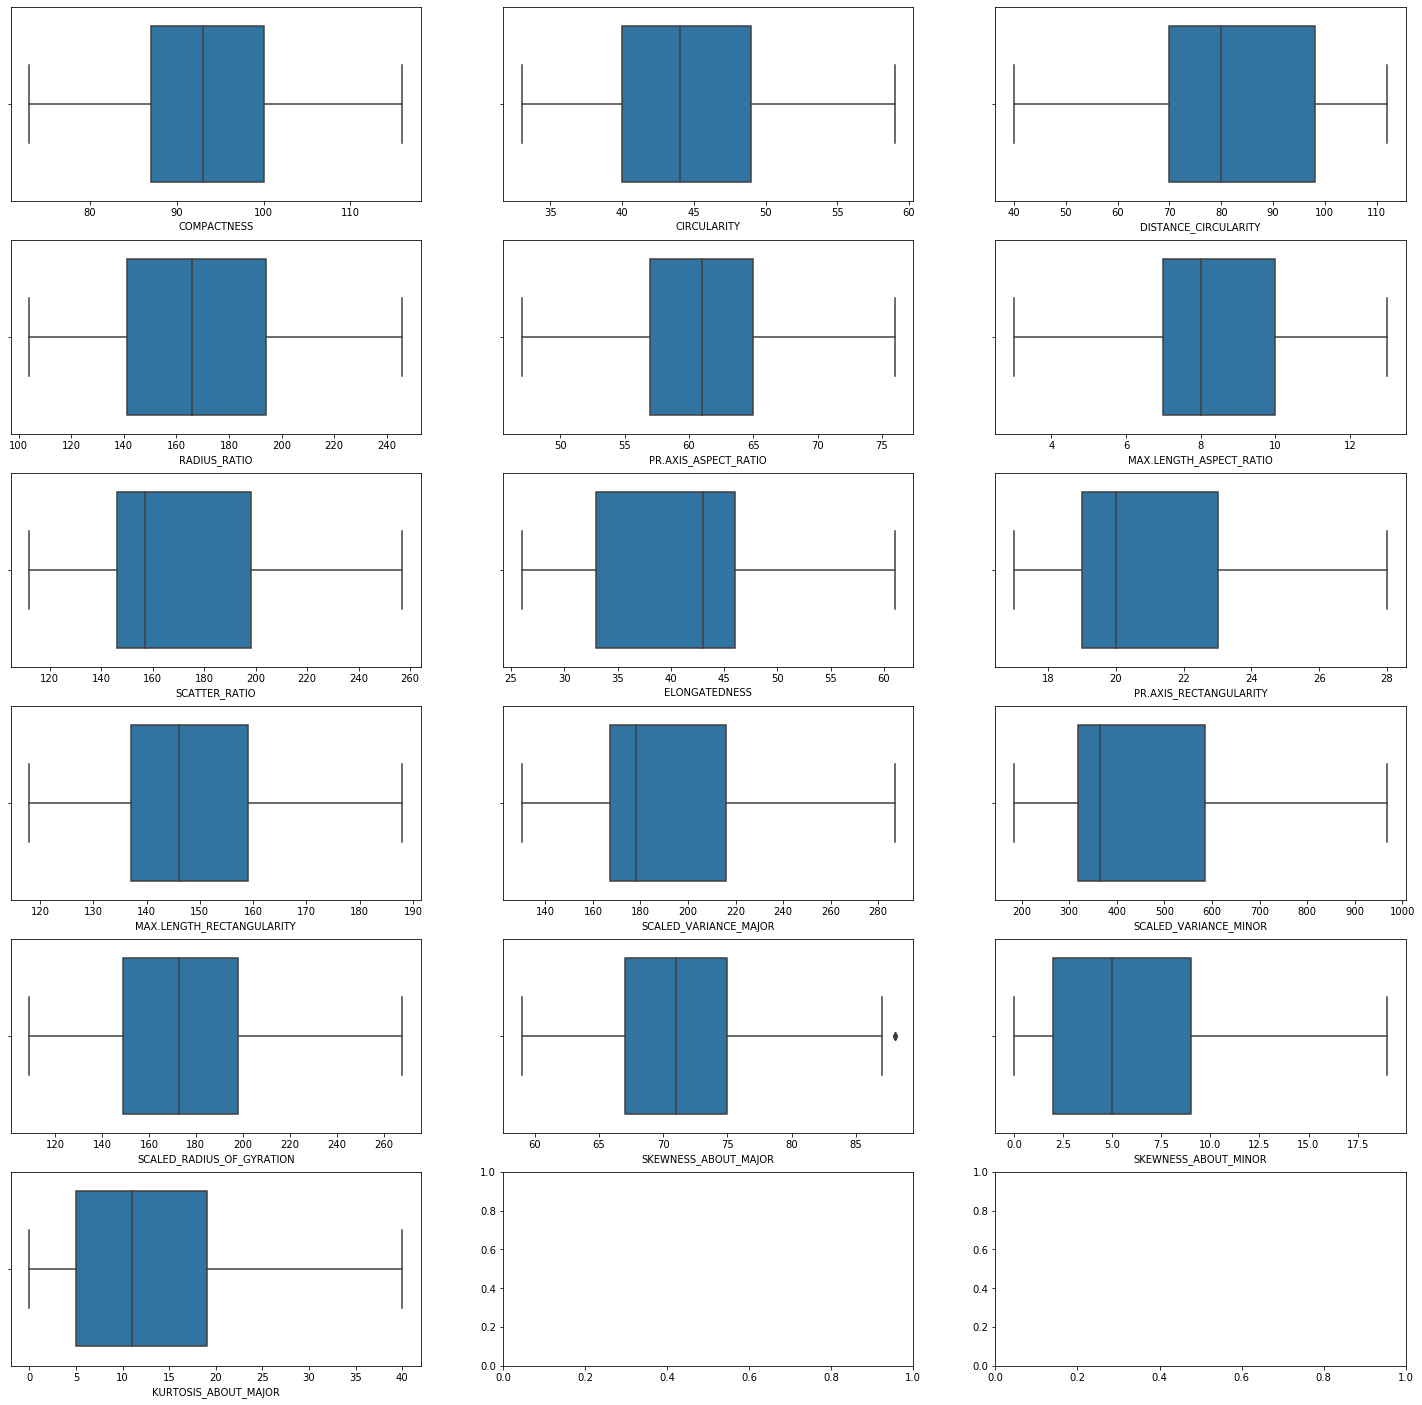

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25, 25))
for i, column in enumerate(feature_cols):
    sns.boxplot(df_new[column],ax=axes[i//3,i%3], dodge=False, whis=1.5)

***Post Outlier Fixing***

I removed all the outliers from the dataset. We can see most of the outliers are fixed in the above boxplot, except 2 outliers in two different columns. I will leave those two outliers as it is because I assume that it will not have much effect on the model accuracy.

**Tran/Test Split Testing**

We will run the training on our model by using different test-train split ratios and check the variation in accuracy. We want to check if the ratio has any relationship with the performance(accuracy) of the model.


***Steps***
1. Data Transformation(MinmaxScaler)
2. Hyperparameter Tuning(GridCV)
    - I am using GridSearchCV function to find the optimal parameters i.e parameter tuning. I will be using rbf(Radial basis kernel). The optimal params value for c and gamma was based on this kaggle kernel (https://www.kaggle.com/rajansharma780/vehicle/kernels).
3. Training using multiple split ratios 
4. Display result in tabular format

In [8]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

X_new = df_new[feature_cols]
y_new = df_new[label_col]

# Initialize Scaler
scaler = MinMaxScaler()

# Estimator - SVM
estimator_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# Disable console messages
estimator_svm.verbose = False

# Run the test and print the results
result_df = test_train_split(estimator_svm, X_new, y_new.values.ravel(), scaler)


    Ratio(Train Data)  Ratio(Test Data)  Accuracy  F1-Score
0                0.90              0.10      0.78      0.78
1                0.85              0.15      0.76      0.75
2                0.80              0.20      0.76      0.76
3                0.75              0.25      0.76      0.76
4                0.70              0.30      0.79      0.79
5                0.65              0.35      0.77      0.76
6                0.60              0.40      0.77      0.76
7                0.55              0.45      0.77      0.76
8                0.50              0.50      0.77      0.77
9                0.45              0.55      0.76      0.76
10               0.40              0.60      0.75      0.74
11               0.35              0.65      0.75      0.74
12               0.30              0.70      0.74      0.73
13               0.25              0.75      0.73      0.72
14               0.20              0.80      0.71      0.70
15               0.15              0.85 

**Result**

From the above table, we can see that test/train data ratio does affect the accuray of the model. Highest accuracy that we get for this data and this setup is 79% when we use 70/30 Train/Test ratio.

***Graph I: Train Data vs Accuracy***

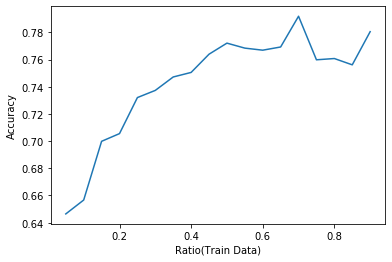

In [11]:
sns.lineplot(data=result_df, x='Ratio(Train Data)', y='Accuracy')

Based on the above experiment, changes in the split ratio did have effect on model accuracy. This is a different setting than the first notebook. Here I have removed the outliers. In this settings, increase in train data does increase the accuracy of the model. However, the increment is not very smooth  or linear.  

At around 75% train data, the accuracy drops and again increases around 90%. But overall result shows that there is the increase in model's performance when test data is increased